In [1]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")

print("Path to dataset files:", path)

100%|██████████| 107M/107M [00:03<00:00, 31.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1


In [50]:
os.listdir(path)

['metadata.csv', 'Mask', 'Image']

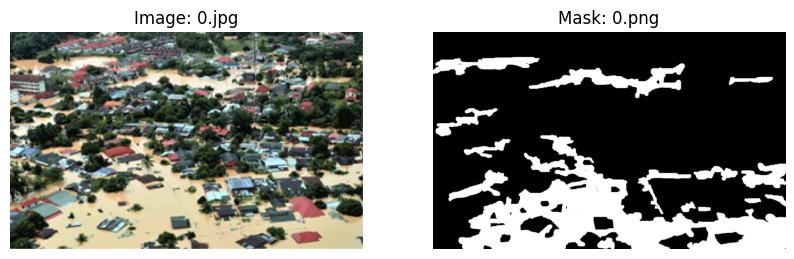

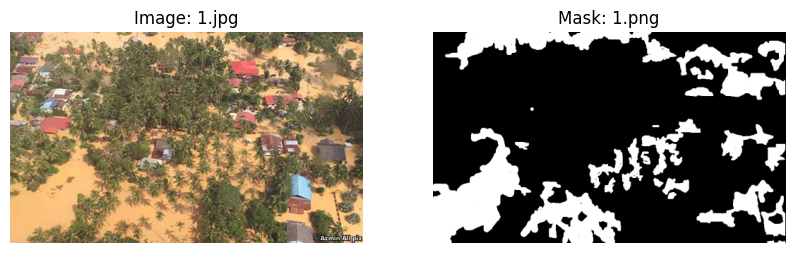

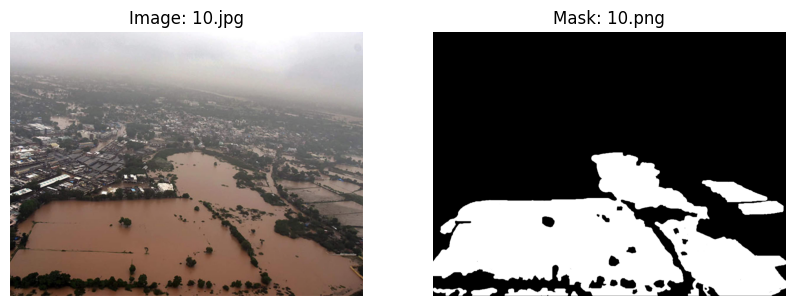

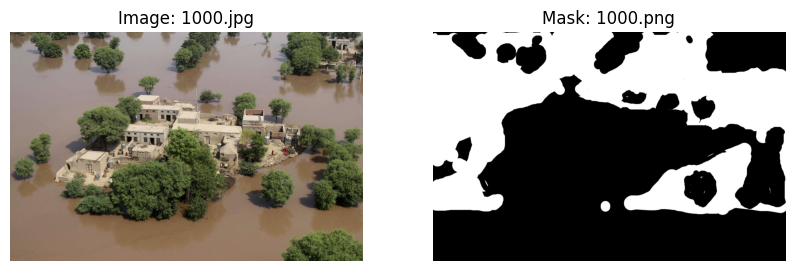

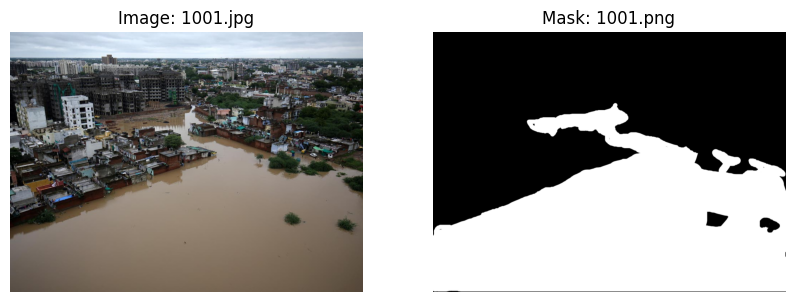

In [79]:
import os
import matplotlib.pyplot as plt
from PIL import Image

image_dir = os.path.join(path, 'Image')
mask_dir = os.path.join(path, 'Mask')

def visualize_images_and_masks(num_images=5):
    image_files = sorted(os.listdir(image_dir))[:num_images]
    mask_files = sorted(os.listdir(mask_dir))[:num_images]

    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = Image.open(img_path)
        mask = Image.open(mask_path)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f"Image: {img_file}")
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Mask: {mask_file}")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.show()

visualize_images_and_masks()


In [77]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import numpy as np

In [137]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

def load_images_and_masks():
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and resize
        img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
        mask = Image.open(mask_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("L")  # Grayscale

        # Normalize image and mask
        images.append(np.array(img) / 255.0)
        masks.append(np.array(mask) / 255.0)

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

# Load dataset
images, masks = load_images_and_masks()

In [138]:
X_train,X_val,y_train,y_val = train_test_split(images,masks,test_size=0.2,random_state=42)

In [139]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape)

(232, 224, 224, 3) (232, 224, 224, 1) (58, 224, 224, 3) (58, 224, 224, 1)


In [87]:
def unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH,3)):
    inputs = Input(input_shape)

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = Concatenate()([u2, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = Concatenate()([u3, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model
unet = unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 224, 224, 16)   │            448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 224, 224, 16)   │          2,320 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 112, 112, 16)   │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 112, 112, 32)   │          4,640 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 32)     │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 56, 56, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 28, 28, 64)     │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 28, 28, 128)    │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 56, 56, 128)    │              0 │ conv2d_22[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 56, 56, 192)    │              0 │ up_sampling2d_3[0][0], │
│ (Concatenate)             │                        │                │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 56, 56, 64)     │        110,656 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_4      

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
history =  unet.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.5235 - loss: 0.6889 - val_accuracy: 0.5748 - val_loss: 0.6317
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.6320 - loss: 0.6051 - val_accuracy: 0.7301 - val_loss: 0.5303
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.7494 - loss: 0.5184 - val_accuracy: 0.6890 - val_loss: 0.5806
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.6227 - loss: 0.6263 - val_accuracy: 0.6904 - val_loss: 0.6274
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7062 - loss: 0.5890 - val_accuracy: 0.7726 - val_loss: 0.4816
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.7416 - loss: 0.5130 - val_accuracy: 0.7763 - val_loss: 0.4698
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.7671 - loss: 0.4680 - val_accuracy: 0.7937 - val_loss: 0.4218
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.7841 - loss: 0.4336 - val_accuracy: 0.8057 - val_loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


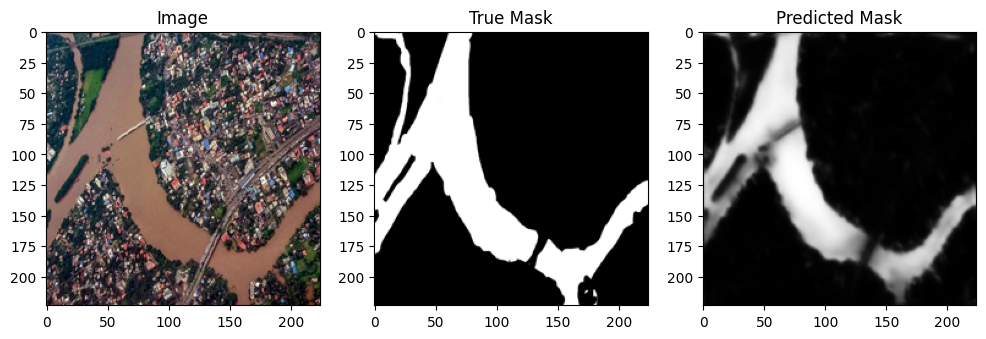

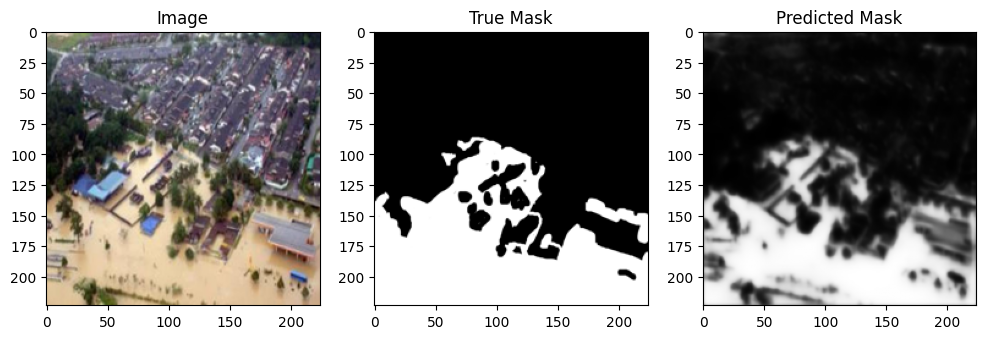

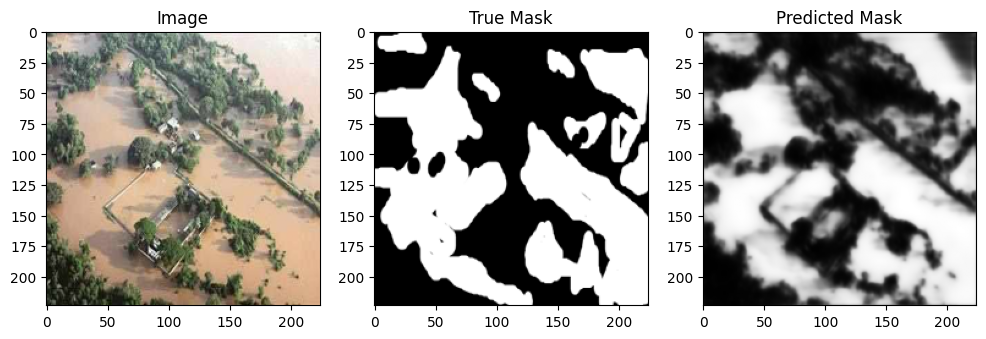

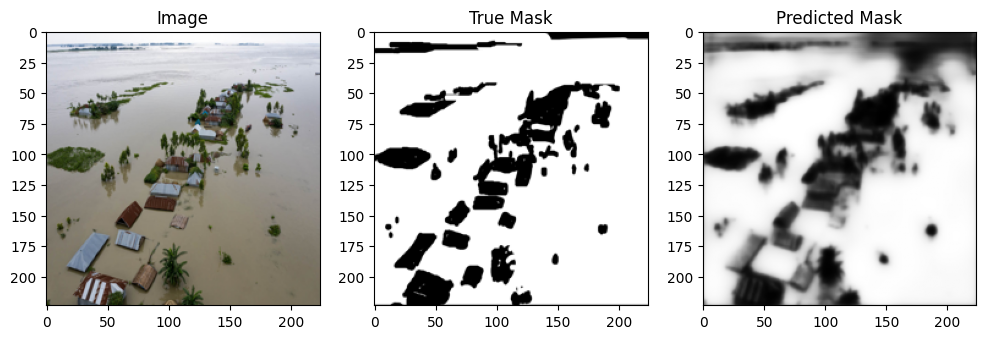

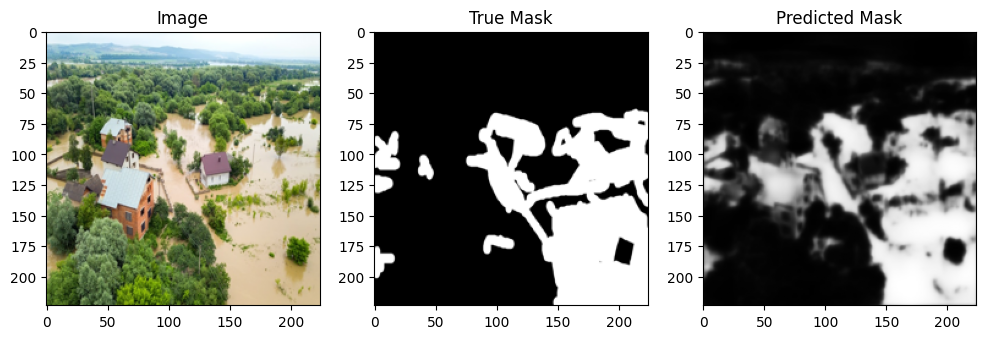

In [89]:
def visualize_predictions(num_images=5):
    preds = unet.predict(X_val[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_val[i])

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_val[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='gray')

        plt.show()

visualize_predictions()

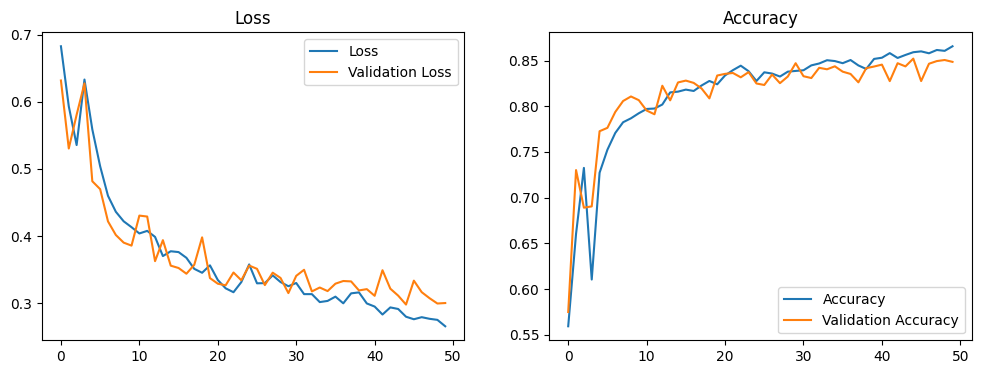

In [134]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [90]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [135]:
def plot_anohter_image_pred(img_path):
    img = load_img(img_path,target_size=(224,224))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    pred = unet.predict(img)
    plt.imshow(img[0])
    plt.show()
    plt.imshow(pred.squeeze(),cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


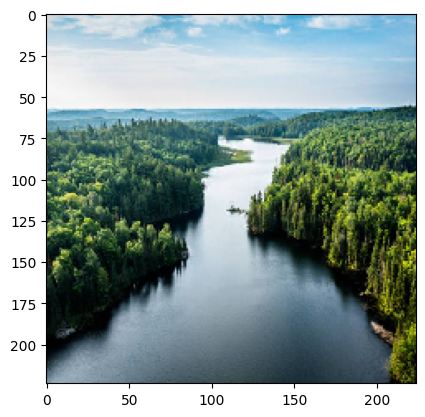

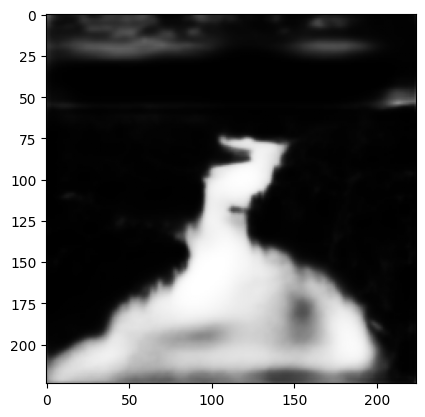

In [136]:
plot_anohter_image_pred("istockphoto-1337232523-612x612.jpg")